# Set-up

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import ipdb
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')  # https://matplotlib.org/users/style_sheets.html
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import plotnine as gg
gg.theme_set(gg.theme_bw)
import time

from AlienTask import Task
from shared_aliens import get_alien_paths, read_in_human_data#, get_summary_rainbow #update_Qs_sim, get_alien_paths, get_alien_initial_q,\
#     get_summary_initial_learn, get_summary_cloudy, simulate_competition_phase, simulate_rainbow_phase, get_summary_rainbow,\
#     read_in_human_data, se, get_chosen_TS
from SimulateAliensJupyterVersionFunctions import *

## Switches etc.

In [2]:
do_save_selected_agents = True
use_mean_or_median = 'median'  # 'mean', 'median', 'already_mean'

In [3]:
# Data paths
## Where is human experimental data stored?
human_data_path = get_alien_paths()["human data prepr"]

## Where will simulated summaries be saved or read in?
summary_save_dir = os.path.join(get_alien_paths()['fitting results'], 'Summaries')
full_summary_save_dir = os.path.join(summary_save_dir, 'FullSimulations')

## Where will plots be saved that we create here?
plot_save_dir = os.path.join(summary_save_dir, 'plots')  # 'C:/Users/maria/MEGAsync/Berkeley/TaskSets/paperplots/'

In [4]:
# Create task, get numbers of trials for each phase
n_sim_per_subj, n_subj = 1, 26  # n_sim_per_sub = 20, n_subj = 31 (version3.1)  # TODO should be 1, 31-x (1 sim per person; exclude excluded subjects)
n_sim = n_sim_per_subj * n_subj
task = Task(n_subj)
n_trials, _, _, _, _ = task.get_trial_sequence(get_alien_paths()["human data prepr"],
                                         n_subj, n_sim_per_subj, range(n_subj),
                                         phases=("1InitialLearning", "2CloudySeason"))

n_trials_ = {'1InitialLearn': np.sum(task.phase == '1InitialLearning'),
             '2CloudySeason': np.sum(task.phase == '2CloudySeason'),
             '4RainbowSeason': 4 * n_aliens,
             '5Competition': 3}

trials = {'1InitialLearn': range(n_trials_['1InitialLearn']),
          '2CloudySeason': range(n_trials_['1InitialLearn'],
                                 n_trials_['1InitialLearn'] + n_trials_['2CloudySeason'])}

# Find good simulations

## Get human and simulation summaries

In [5]:
# Get human raw data
n_hum, hum_aliens, hum_seasons, hum_corrects, hum_actions, hum_rewards, hum_rainbow_dat, hum_comp_dat = read_in_human_data(
    human_data_path, 828, n_aliens, n_actions, exclude=['160',])  # '164' -> already excluded for head trauma

# Calculate human summaries
(hum_summary_initial_learn, hum_summary_cloudy, hum_summary_competition,
hum_summary_rainbow, hum_regr_coefs) = get_human_summaries(
    n_hum, hum_aliens, hum_seasons, hum_corrects, hum_actions,
    hum_rewards, hum_rainbow_dat, hum_comp_dat, trials, task, n_seasons)

Reading in human data from C:/Users/maria/MEGAsync/Berkeley/TaskSets/Data/version3.1preprocessed/!
1 subjects were exlcuded: ['160']


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
# Read in all summaries
filenames = glob.glob(os.path.join(summary_save_dir, '*.csv'))
filenames = [filename for filename in filenames if 'summar' in filename]  # don't read in selected_agents.csv etc.
print('Found {} files.'.format(len(filenames)))

all_summaries = read_in_all_summaries(filenames)
print("Number of samples: {} (flat: {}; hier: {}; Bayes: {})".
      format(all_summaries.shape[0],
             np.sum(all_summaries['model'] == 'flat'),
             np.sum(all_summaries['model'] == 'hier'),
             np.sum(all_summaries['model'] == 'Bayes')
))

Found 151 files.
Number of samples: 150001 (flat: 50000; hier: 50000; Bayes: 50001)


## Select simulations based on similarity to humans

In [7]:
def get_selected_agents(width):
    
    lower = (10 - width/2) / 10
    upper = (10 + width/2) / 10

    # Get masks for each effects
    IL_acc_prev_TS = (
            all_summaries['IL_acc_prev_TS'] > lower * hum_summary_initial_learn['IL_acc_prev_TS'].values[0]) & (
            all_summaries['IL_acc_prev_TS'] < upper * hum_summary_initial_learn['IL_acc_prev_TS'].values[0])
    IL_acc_current_TS = (
            all_summaries['IL_acc_current_TS'] > lower * hum_summary_initial_learn['IL_acc_current_TS'].values[0]) & (
            all_summaries['IL_acc_current_TS'] < upper * hum_summary_initial_learn['IL_acc_current_TS'].values[0])
    CO_acc_season = (
            all_summaries['CO_acc_season'] > lower * hum_summary_competition['CO_acc_season'].values[0]) & (
            all_summaries['CO_acc_season'] < upper * hum_summary_competition['CO_acc_season'].values[0])
    CO_acc_season_alien = (
            all_summaries['CO_acc_season_alien'] > lower * hum_summary_competition['CO_acc_season_alien'].values[0]) & (
            all_summaries['CO_acc_season_alien'] < upper * hum_summary_competition['CO_acc_season_alien'].values[0])
    CL_slope = (
            all_summaries['CL_slope'] > lower * hum_summary_cloudy['CL_slope'].values[0]) & (
            all_summaries['CL_slope'] < upper * hum_summary_cloudy['CL_slope'].values[0])
    Qts_1InitialLearn_mean = (
            all_summaries['Qts_1InitialLearn_mean'] > lower * hum_regr_coefs['Qts_1InitialLearn_mean'].values[0]) & (
            all_summaries['Qts_1InitialLearn_mean'] < upper * hum_regr_coefs['Qts_1InitialLearn_mean'].values[0])
    Qa_1InitialLearn_mean = (
            all_summaries['Qa_1InitialLearn_mean'] > lower * hum_regr_coefs['Qa_1InitialLearn_mean'].values[0]) & (
            all_summaries['Qa_1InitialLearn_mean'] < upper * hum_regr_coefs['Qa_1InitialLearn_mean'].values[0])

    # Subset data
    selected_agents = all_summaries.loc[
        IL_acc_prev_TS & IL_acc_current_TS & CO_acc_season & CO_acc_season_alien & CL_slope
        & Qts_1InitialLearn_mean & Qa_1InitialLearn_mean
    ]  # IL_acc_prev_TS & CL_slope & CO_season_minus_alien & IL_perf_TS2minus1
    selected_agents = selected_agents.reset_index()

    # Count models
    model_ns = [selected_agents.loc[selected_agents['model'] == model,].shape[0] for model in models]

    return selected_agents, model_ns

# Example use
get_selected_agents(6)[0]

,index,CL_acc_trial0,CL_acc_trial0_se,CL_acc_trial1,CL_acc_trial1_se,CL_acc_trial2,CL_acc_trial2_se,CL_acc_trial3,CL_acc_trial3_se,CL_first_None,...,IL_first_TS0_minus_TS1,IL_first_TS1_minus_TS2,CL_first_TS0_minus_TS2,CL_first_TS0_minus_TS1,CL_first_TS1_minus_TS2,CL_slope_TS0minusTS2,CL_slope_TS0minusTS1,CL_slope_TS1minusTS2,Qts_minus_a_1InitialLearn,Qts_minus_a_2CloudySeason
0,50133,0.324786,0.023347,0.324786,0.033608,0.380342,0.033198,0.384615,0.041535,0.121394,...,0.020433,0.070913,0.158654,0.015625,0.143029,-0.044872,0.076923,-0.121795,-0.143365,-0.103152
1,53802,0.354701,0.027708,0.418803,0.021203,0.440171,0.021351,0.427350,0.026129,0.033654,...,0.014423,0.092548,0.293269,0.058894,0.234375,-0.096154,-0.070513,-0.025641,-0.148578,0.003670
2,54663,0.307692,0.024406,0.337607,0.037490,0.324786,0.030771,0.414530,0.026727,0.140625,...,-0.006010,0.110577,0.093750,-0.016827,0.110577,-0.224359,-0.179487,-0.044872,-0.125987,-0.088273
3,54896,0.311966,0.033113,0.371795,0.032514,0.337607,0.035999,0.401709,0.035280,0.116587,...,-0.001202,0.082933,0.135817,0.014423,0.121394,-0.384615,-0.179487,-0.205128,-0.118289,-0.140816
4,56018,0.324786,0.033060,0.337607,0.029286,0.341880,0.035200,0.410256,0.039060,0.132212,...,-0.037260,0.093750,0.081731,-0.002404,0.084135,-0.282051,-0.032051,-0.250000,-0.166822,-0.110973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,146571,0.213675,0.021726,0.264957,0.024975,0.269231,0.030919,0.320513,0.025157,0.117788,...,-0.013221,0.111779,0.151442,0.024038,0.127404,-0.121795,0.115385,-0.237179,-0.202661,-0.160838
90,147553,0.277778,0.027196,0.286325,0.028459,0.290598,0.021003,0.354701,0.028360,0.105769,...,-0.037260,0.093750,0.074519,-0.019231,0.093750,0.237179,0.102564,0.134615,-0.136960,0.065851
91,147857,0.269231,0.033743,0.286325,0.027145,0.341880,0.028298,0.316239,0.030634,0.134615,...,-0.018029,0.115385,0.106971,0.022837,0.084135,0.019231,0.089744,-0.070513,-0.113468,-0.099104
92,148597,0.277778,0.029141,0.320513,0.032729,0.282051,0.032111,0.358974,0.027898,0.164663,...,-0.024038,0.118990,0.123798,-0.015625,0.139423,-0.025641,-0.108974,0.083333,-0.107703,-0.045936


In [8]:
# How many models do we get depending on width of interval?
widths = np.arange(0, 50)

all_ns = []
for width in widths:
    selected_agents, model_ns = get_selected_agents(width)
    all_ns += [model_ns + [width]]

all_ns = pd.DataFrame(data=all_ns, columns=['n_{}'.format(m) for m in models] + ['width'])

In [9]:
all_ns_long = pd.melt(all_ns, id_vars=('width'), var_name='model', value_name='n')
all_ns_long['log_n'] = np.log(all_ns_long['n'])

gg.options.figure_size = (3, 2)
g = (gg.ggplot(all_ns_long, gg.aes('width', 'n', color='model'))
 + gg.geom_point()
 + gg.geom_vline(xintercept=10)
)
g.save(os.path.join(plot_save_dir, 'NSelectedSimulationsOverWidth.png'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 3 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/TaskSets/models\Summaries\plots\NSelectedSimulationsOverWidth.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Found 727 agents: ['hier', 'Bayes', 'flat'], [290, 0, 437]
Saving selected_agents to C:/Users/maria/MEGAsync/Berkeley/TaskSets/models\Summaries/selected_agents_width10.csv


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


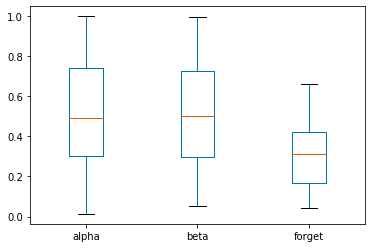

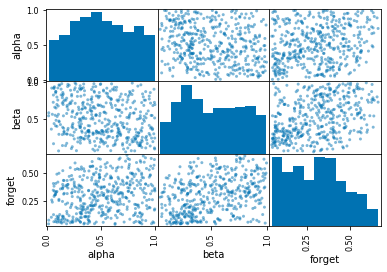

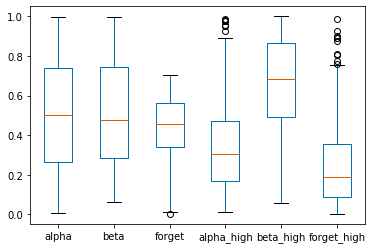

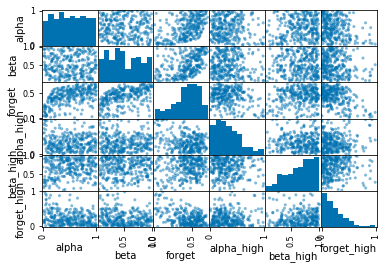

In [10]:
# Select agents for one width
width = 10  # Bayes: 18; flat & hier: 10
selected_agents, model_ns = get_selected_agents(width=width)
print("Found {} agents: {}, {}".format(selected_agents.shape[0], models, model_ns))

# Save selected_agents as csv
if do_save_selected_agents:
    save_path = summary_save_dir + '/selected_agents_width{}.csv'.format(width)
    print("Saving selected_agents to {}".format(save_path))
    selected_agents.to_csv(save_path, index=False)

for model_name in np.unique(selected_agents['model']):
    param_names, param_range = get_param_names_ranges(model_name)
    sub_dat = selected_agents.loc[selected_agents['model'] == model_name]
    sub_dat[['beta', 'beta_high']] /= 20
    sub_dat[param_names].plot(kind='box', by='model')
    plt.savefig(os.path.join(plot_save_dir, 'S0ParamBox_{}.png'.format(model_name)))
    scatter_matrix(sub_dat[param_names])
    plt.savefig(os.path.join(plot_save_dir, 'S0ParamCorrelations_{}.png'.format(model_name)))

## Make one simulation, based on median selected parameters

In [11]:
if use_mean_or_median == 'median':

    # Get n_sim and task
    n_sim_per_subj, n_subj = 10, 26  # n_sim_per_sub = 20, n_subj = 31 (version3.1)  # TODO should be 1, 31-x (1 sim per person; exclude excluded subjects)
    n_sim = n_sim_per_subj * n_subj
    task = Task(n_subj)
    n_trials, _, _, _, _ = task.get_trial_sequence(
        get_alien_paths()["human data prepr"], n_subj, n_sim_per_subj,
        range(n_subj), phases=("1InitialLearning", "2CloudySeason"))

    # Get parameters
    selected_params = selected_agents[['alpha', 'beta', 'forget', 'alpha_high', 'beta_high', 'forget_high', 'model']]
    sim_params = selected_params.groupby('model').aggregate('median').reset_index()

    # Simulate big populations
    mean_summary = pd.DataFrame()
    for model_name in np.unique(selected_agents['model']):

        param_names, param_ranges = get_param_names_ranges(model_name)

        params_0inf = sim_params.loc[sim_params['model'] == model_name, param_names]
        params_01 = (params_0inf - param_ranges.loc[0]) / (param_ranges.loc[1] - param_ranges.loc[0])
        param_values = params_01.values.flatten()

        # Get summaries for one full dataset
        print("Simulating {} {} agents with parameters:\n{}\n".format(n_sim, model_name, params_0inf))
        alien_initial_Q = get_alien_initial_q(model_name)
        sim_summary = get_summary(
            task, model_name, param_values, param_ranges,
            n_sim, trials, n_trials, n_trials_, alien_initial_Q, summary_or_fulldata='summary')
        sim_summary = sim_summary.T
        sim_summary['model'] = model_name
        
#         # Get full data and save like humans
#         seasons, corrects, rewards, aliens, actions, TSs = get_summary(
#             task, model_name, param_values, param_ranges,
#             n_sim, trials, n_trials, n_trials_, alien_initial_Q, summary_or_fulldata='fulldata')

#         for agentID in range(n_sim):
#             subj_data = pd.DataFrame()
#             subj_data["context"] = seasons[:, agentID]
#             subj_data["sad_alien"] = aliens[:, agentID]
#             subj_data["item_chosen"] = actions[:, agentID]
#             subj_data["reward"] = rewards[:, agentID]
#             subj_data["correct"] = corrects[:, agentID]
#             subj_data["trial_type"] = "feed-aliens"
#             subj_data["trial_index"] = np.arange(n_trials)
#             subj_data["subjID"] = agentID
#             subj_data["block.type"] = "normal"
#             subj_data["model_name"] = model_name
#             subj_data["phase"] = ['1InitialLearning'] * n_trials_['1InitialLearn'] + ['2CloudySeason'] * n_trials_['2CloudySeason']
#             for i, param_name in enumerate(param_names):
#                 subj_data[param_name] = param_values[i]

#             # Save to disc
#             file_name = "{}/aliens_{}_modelidx{}_agent_{}.csv".format(
#                 full_summary_save_dir, model_name, use_mean_or_median, agentID)
#             print('Saving file {}'.format(file_name))
#             subj_data.to_csv(file_name)
            
        mean_summary = mean_summary.append(sim_summary)
    mean_summary = mean_summary.set_index('model')
    mean_summary

Simulating 260 flat agents with parameters:
      alpha       beta    forget
0  0.493891  10.058606  0.310667

Simulating 260 hier agents with parameters:
      alpha      beta    forget  alpha_high  beta_high  forget_high
1  0.499293  9.512745  0.455769    0.304918  13.662117     0.188132



## Get summaries for all methods

In [12]:
if (use_mean_or_median == 'already_mean') or (use_mean_or_median == 'median'):
    rows = mean_summary.index
elif (use_mean_or_median == 'mean'):
    rows = range(len(save_summaries))  # TODO: integrate to make prettier

save_summaries_rainbow = pd.DataFrame()
sim_rainbow_dat = list()

for row in rows:
    model_dat = mean_summary.loc[row, RB_cols]
    mod_sim_rainbow_dat = model_dat.values.reshape((n_aliens, n_actions))
    mod_save_summaries_rainbow = get_summary_rainbow(n_aliens, n_seasons, mod_sim_rainbow_dat, task)
    mod_save_summaries_rainbow = pd.DataFrame(
        data=np.expand_dims(mod_save_summaries_rainbow, axis=0),
        columns=RB_sum_cols)
#     mod_save_summaries_rainbow['model'] = mean_summary.loc[model]

    save_summaries_rainbow = save_summaries_rainbow.append(mod_save_summaries_rainbow)
    sim_rainbow_dat.append(mod_sim_rainbow_dat)

save_summaries_rainbow['TS1minusTS2'] = save_summaries_rainbow['TS1'] - save_summaries_rainbow['TS2']
save_summaries_rainbow['TS0minusTS2'] = save_summaries_rainbow['TS0'] - save_summaries_rainbow['TS2']
save_summaries_rainbow

,TS0,TS1,TS2,None,TS0_se,TS1_se,TS2_se,None_se,TS1minusTS2,TS0minusTS2
0,0.353208,0.340212,0.290864,0.139557,0.0,0.0,0.0,0.0,0.049348,0.062344
0,0.358895,0.341798,0.274713,0.126695,0.0,0.0,0.0,0.0,0.067084,0.084182


## Plot bar graphs for humans and agents

In [13]:
# Plot human behavior & selected_agents
def make_plot(hum_mean, ag_mean, hum_se=False, ag_se=False, plot_name="plot.png", ylabel="",
              hline=False, ylim=False, xlabel="", xticklabels=False, figsize=(8,4), plotted_models=models):

    if not np.any(hum_se):
        hum_se = np.zeros(len(hum_mean.T))
    if not np.any(ag_se):
        ag_se = np.zeros(3)
    if not xticklabels:
        xticklabels = ""

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=figsize)
    [ax.set_title(title) for ax, title in zip(axes, ['Humans'] + plotted_models)]

    axes[0].bar(range(len(hum_mean)), hum_mean, yerr=hum_se, tick_label=xticklabels, color='grey')
    for i_model in range(len(plotted_models)):
        axes[i_model+1].bar(range(len(hum_mean)), ag_mean[i_model], yerr=ag_se[i_model],
                          tick_label=xticklabels, color='grey')

    [ax.set_ylabel(ylabel) for ax in axes]
    [ax.set_xlabel(xlabel) for ax in axes]

    if ylim:
        [ax.set_ylim(ylim) for ax in axes]
    if hline:
        [ax.axhline(y=hline, color='black', linestyle='--') for ax in axes]

    plt.tight_layout()
    plt.savefig(os.path.join(plot_save_dir, plot_name))

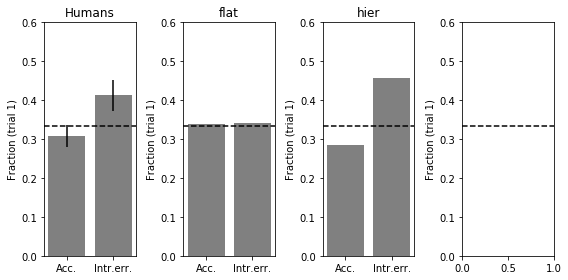

In [14]:
# Plot intrusion errors
plotted_models = list(mean_summary.index.values)

make_plot(hum_summary_initial_learn[IL_cols[3:5]].values.flatten(), mean_summary[IL_cols[3:5]].values,
          hum_summary_initial_learn[IL_cols[6:8]].values.flatten(), #mean_summary[IL_cols[6:8]].values,
          plot_name='1intrusion_errors_{}.png'.format(use_mean_or_median), figsize=(8, 4),
          ylabel="Fraction (trial 1)", hline=1/3, ylim=(0, 0.6), xticklabels=['Acc.', 'Intr.err.'],
          plotted_models=plotted_models)

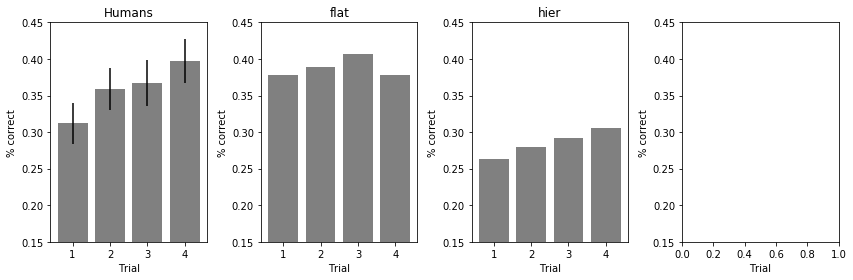

In [15]:
# Plot TS reactivation
make_plot(hum_summary_cloudy[CL_cols[:4]].values.flatten(), mean_summary[CL_cols[:4]].values,
          hum_summary_cloudy[CL_cols[4:8]].values.flatten(), #mean_summary[CL_cols[4:8]].values,
          plot_name='0TS_react_{}.png'.format(use_mean_or_median), figsize=(12, 4),
          ylabel="% correct", hline=False, ylim=(0.15, 0.45),
          xlabel="Trial", xticklabels=range(1, n_aliens+1),
          plotted_models=plotted_models)

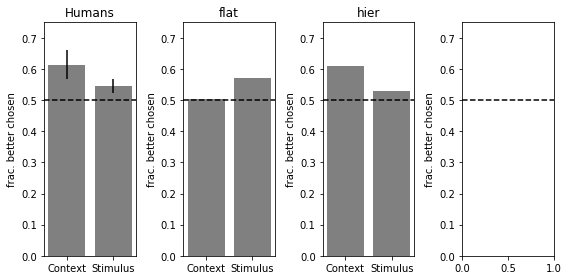

In [16]:
# TS values affect preference
make_plot(hum_summary_competition[CO_cols[:2]].values.flatten(), mean_summary[CO_cols[:2]].values,
          hum_summary_competition[CO_cols[2:4]].values.flatten(), #mean_summary[CO_cols[2:4]].values,
          plot_name='3TS_values_preference_{}.png'.format(use_mean_or_median), figsize=(8, 4),
          ylabel="frac. better chosen", hline=1/2, ylim=(0, 0.75), xticklabels=['Context', 'Stimulus'],
          plotted_models=plotted_models)

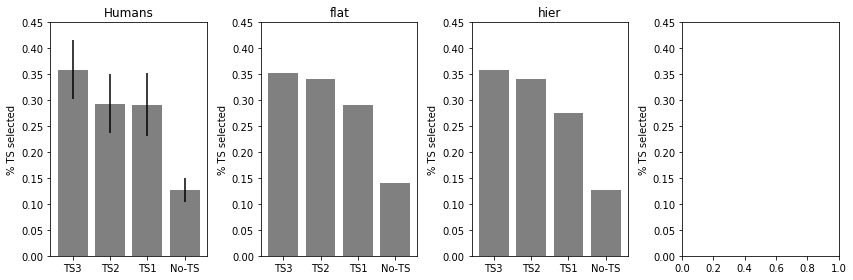

In [17]:
# Plot TS values affect generalization
make_plot(hum_summary_rainbow[RB_sum_cols[:4]].values.flatten(), save_summaries_rainbow[RB_sum_cols[:4]].values,
          hum_summary_rainbow[RB_sum_cols[4:8]].values.flatten(), #save_summaries_rainbow[RB_sum_cols[:4]].values,
          plot_name='4TS_values_generalization_{}.png'.format(use_mean_or_median), figsize=(12, 4),
          ylabel='% TS selected', ylim=(0, 0.45), xticklabels=['TS3', 'TS2', 'TS1', 'No-TS'],
          plotted_models=plotted_models)

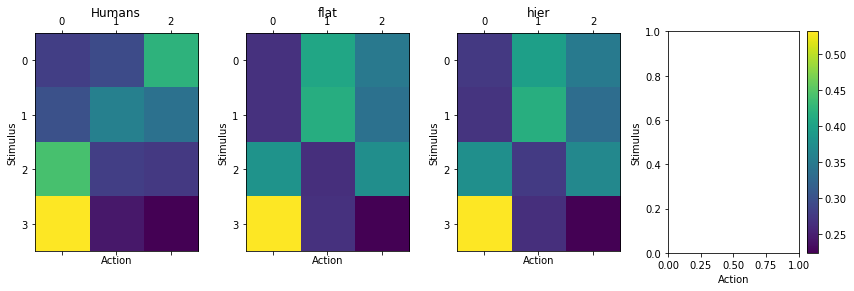

In [18]:
# Rainbow phase action heatmaps
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
[ax.set_title(title) for ax, title in zip(axes, ['Humans'] + plotted_models)]
cax1 = axes[0].matshow(hum_rainbow_dat[0])
for i in range(len(plotted_models)):
    axes[i+1].matshow(pd.DataFrame(sim_rainbow_dat[i]).astype(float))
[ax.set_xlabel('Action') for ax in axes]
[ax.set_ylabel('Stimulus') for ax in axes]
plt.colorbar(cax1)

plt.tight_layout()
plt.savefig(os.path.join(plot_save_dir, '4TS_values_generalization_heatmap_{}.png'.format(use_mean_or_median)))

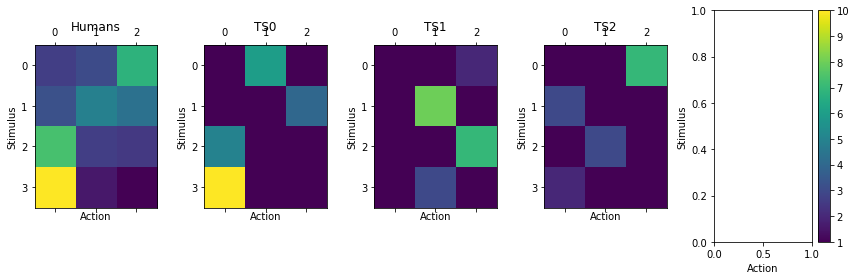

In [19]:
# Plot heatmaps for all TS
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
[ax.set_title(title) for ax, title in zip(axes, ['Humans'] + ['TS{}'.format(i) for i in range(3)])]
cax1 = axes[0].matshow(hum_rainbow_dat[0])
for i in range(3):
    cax = axes[i+1].matshow(pd.DataFrame(task.TS[i]).astype(float), vmin=1, vmax=10)
[ax.set_xlabel('Action') for ax in axes]
[ax.set_ylabel('Stimulus') for ax in axes]
plt.colorbar(cax)

plt.tight_layout()
plt.savefig(os.path.join(plot_save_dir, '4TS_values_generalization_TSheatmaps_{}.png'.format(use_mean_or_median)))

# Old or alternative code

## Re-simulate all selected simulations

In [20]:
if use_mean_or_median == 'mean':

    # Get n_sim and task
    n_sim_per_subj, n_subj = 1, 26  # n_sim_per_sub = 20, n_subj = 31 (version3.1)  # TODO should be 1, 31-x (1 sim per person; exclude excluded subjects)
    n_sim = n_sim_per_subj * n_subj
    task = Task(n_subj)
    n_trials, _, _, _, _ = task.get_trial_sequence(
        get_alien_paths(False)["human data prepr"], n_subj, n_sim_per_subj,
        range(n_subj), phases=("1InitialLearning", "2CloudySeason"))

    # Run simulations
    summaries = pd.DataFrame()
    for row in range(len(selected_agents)):

        model_name = selected_agents.loc[row, 'model']
        param_names, param_ranges = get_param_names_ranges(model_name)

        params_0inf = selected_agents.loc[row, param_names]
        params_01 = (params_0inf - param_ranges.loc[0]) / (param_ranges.loc[1] - param_ranges.loc[0])
        params = params_01.values.flatten()

        alien_initial_Q = get_alien_initial_q(model_name)
        new_summary = get_summary(
            task, model_name, params, param_ranges,
            n_sim, trials, n_trials, n_trials_, alien_initial_Q, summary_or_fulldata='summary')
        new_summary.loc['model'] = model_name
        summaries = pd.concat([summaries, new_summary], axis=1, sort=False)

        # Print progress
        if (row % 10) == 0:
            print("\n\tIteration {} / {}".format(row, len(selected_agents)))
            print("Model: {}".format(model_name))
            print("Parameters:\n{}".format(params_0inf))
            
        # Save summaries to disk
        if ((row % 50) == 0) or (row == len(selected_agents) - 1):
            save_path = os.path.join(summary_save_dir, 'resimulated_summaries_{}.csv'.format(use_mean_or_median))
            save_summaries = summaries.T
            save_summaries.to_csv(save_path)
            print("Saving summaries to {}".format(save_path))

In [21]:
# save_summary = pd.read_csv(save_path)

In [22]:
if use_mean_or_median == 'mean':
    save_summaries = save_summaries.reset_index(drop=True)
    for col in [c for c in save_summaries.columns if c != 'model']:
        save_summaries[col] = save_summaries[col].astype(float)

    mean_summary = save_summaries.groupby('model').aggregate('mean')
    save_summaries, mean_summary

## Use already-simulated data directly

In [ ]:
if use_mean_or_median == 'already_mean':

    mean_summary = selected_agents.groupby('model').aggregate('mean')
    print(mean_summary)

In [ ]:
# if use_mean_or_median == 'mean':
#     save_summaries_rainbow = pd.DataFrame()
#     sim_rainbow_dat = list()

#     for row in range(len(save_summaries)):
#         model_dat = save_summaries.loc[row, RB_cols]
#         mod_sim_rainbow_dat = model_dat.values.reshape((n_aliens, n_actions))
#         mod_save_summaries_rainbow = get_summary_rainbow(n_aliens, n_seasons, mod_sim_rainbow_dat, task)
#         mod_save_summaries_rainbow = pd.DataFrame(
#             data=np.expand_dims(mod_save_summaries_rainbow, axis=0),
#             columns=RB_sum_cols)

#         save_summaries_rainbow = save_summaries_rainbow.append(mod_save_summaries_rainbow)
#         sim_rainbow_dat.append(mod_sim_rainbow_dat)

#     save_summaries_rainbow['TS1minusTS2'] = save_summaries_rainbow['TS1'] - save_summaries_rainbow['TS2']
#     save_summaries_rainbow['TS0minusTS2'] = save_summaries_rainbow['TS0'] - save_summaries_rainbow['TS2']
#     save_summaries_rainbow

In [ ]:
# if use_mean_or_median == 'median':

#     save_summaries_rainbow = pd.DataFrame()
#     sim_rainbow_dat = list()

#     for row in mean_summary.index:
#         model_dat = mean_summary.loc[row, RB_cols]
#         mod_sim_rainbow_dat = model_dat.values.reshape((n_aliens, n_actions))
#         mod_save_summaries_rainbow = get_summary_rainbow(n_aliens, n_seasons, mod_sim_rainbow_dat, task)
#         mod_save_summaries_rainbow = pd.DataFrame(
#             data=np.expand_dims(mod_save_summaries_rainbow, axis=0),
#             columns=RB_sum_cols)

#         save_summaries_rainbow = save_summaries_rainbow.append(mod_save_summaries_rainbow)
#         sim_rainbow_dat.append(mod_sim_rainbow_dat)

#     save_summaries_rainbow['TS1minusTS2'] = save_summaries_rainbow['TS1'] - save_summaries_rainbow['TS2']
#     save_summaries_rainbow['TS0minusTS2'] = save_summaries_rainbow['TS0'] - save_summaries_rainbow['TS2']
#     save_summaries_rainbow

# Old stuff

In [ ]:
def scale_parameters(parameters, param_ranges):
    
    ## Scale parameters correctly
    parameters = param_ranges.loc[0] + (param_ranges.loc[1] - param_ranges.loc[0]) * parameters

    beta_shape = (n_sim, 1)  # Q_low_sub.shape -> [n_subj, n_actions]
    beta_high_shape = (n_sim, 1)  # Q_high_sub.shape -> [n_subj, n_TS]
    forget_shape = (n_sim, 1, 1, 1)  # Q_low[0].shape -> [n_subj, n_TS, n_aliens, n_actions]
    forget_high_shape = (n_sim, 1, 1)  # -> [n_subj, n_seasons, n_TS]

    ## Parameters present in all models (flat RL, hier RL, Bayes)
    alpha = parameters['alpha'] * np.ones(n_sim)
    beta = parameters['beta'] * np.ones(beta_shape)
    forget = parameters['forget'] * np.ones(forget_shape)

    ## Deal with parameters that exist only in some models
    try:
        alpha_high = parameters['alpha_high'] * np.ones(n_sim)
    except KeyError:
        alpha_high = np.zeros(n_sim)
    try:
        beta_high = parameters['beta_high'] * np.ones(beta_high_shape)
    except KeyError:
        beta_high = np.zeros(beta_high_shape)
    try:
        forget_high = parameters['forget_high'] * np.ones(forget_high_shape)
    except KeyError:
        forget_high = np.zeros(forget_high_shape)

    return alpha, beta, forget, alpha_high, beta_high, forget_high

In [ ]:
def simulate_initial_learn(n_trials, n_sim, n_TS, n_aliens, n_actions, n_seasons,
                           alpha, beta, forget, alpha_high, beta_high, forget_high,
                           alien_initial_Q, trials, task):
    
    ## Set up data storage
    seasons = np.zeros([n_trials, n_sim], dtype=int)
    corrects = np.zeros([n_trials, n_sim])
    rewards = np.zeros([n_trials, n_sim])
    aliens = np.zeros([n_trials, n_sim], dtype=int)
    actions = np.zeros([n_trials, n_sim], dtype=int)

    ## Inialize Q-values
    Q_low = alien_initial_Q * np.ones([n_sim, n_TS, n_aliens, n_actions])
    Q_high = alien_initial_Q * np.ones([n_sim, n_seasons, n_TS])

    ## Simulate behavior
    for trial in trials['1InitialLearn']:

        ### Observe stimuli
        season, alien = task.present_stimulus(trial)

        ### Select action & update Q-values
        [Q_low, Q_high, TS, action, correct, reward, p_low] =\
            update_Qs_sim(season, alien,
                          Q_low, Q_high,
                          beta, beta_high, alpha, alpha_high, forget, forget_high,
                          n_sim, n_actions, n_TS, task, alien_initial_Q, model_name)

        ### Store trial data
        seasons[trial] = season
        corrects[trial] = correct
        rewards[trial] = reward
        aliens[trial] = alien
        actions[trial] = action

    return Q_low, Q_high, seasons, corrects, rewards, aliens, actions, season

In [ ]:
def simulate_cloudy(trials, season, task):

    for trial in trials['2CloudySeason']:

        ## Observe trial stimuli
        old_season = season.copy()
        season, alien = task.present_stimulus(trial)

        ## Season switches
        if trial == list(trials['2CloudySeason'])[0]:
            season_switches = np.ones(n_sim, dtype=bool)
        else:
            season_switches = season != old_season

        ## Reset Q-values after season switches
        if (model_name == 'hier') or (model_name == 'Bayes'):
            Q_high[season_switches] = alien_initial_Q  # re-start search for the right TS when season changes
        elif model_name == 'flat':
            Q_low[season_switches] = alien_initial_Q  # re-learn a new policy from scratch when season changes
        else:
            raise(NameError, 'Model_name must be "flat", "hier", or "Bayes".')

        ## Update Q-values
        [Q_low, Q_high, TS, action, correct, reward, p_low] =\
            update_Qs_sim(0 * season, alien,
                          Q_low, Q_high,
                          beta, beta_high, alpha, alpha_high, forget, forget_high,
                          n_sim, n_actions, n_TS, task, alien_initial_Q, model_name)

        ## Store trial data
        seasons[trial] = season
        corrects[trial] = correct
        rewards[trial] = reward
        aliens[trial] = alien
        actions[trial] = action

    return seasons, corrects, aliens, actions